# 1. Structuring the Table

**Meteora** is a store that sells clothing and accessories from various brands across all states in Brazil. The goal is to understand its databases and display relevant information to support decision-making.

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine, inspect, text

**About the Tables**
- itens_pedidos: table that provides information about what was sold, including price, quantity, shipping destination, and shipping cost

- pedidos: refers to the completed sales, with details about sellers, order price, and sales date

- produtos: contains information about the characteristics of the products sold in the store

- vendedores: contains the names of the sellers

In [40]:
url_itens_pedidos = 'https://github.com/alura-cursos/SQL-python-integracao/raw/main/TABELAS/itens_pedidos.csv'
url_pedidos = 'https://github.com/alura-cursos/SQL-python-integracao/raw/main/TABELAS/pedidos.csv'
url_produto = 'https://github.com/alura-cursos/SQL-python-integracao/raw/main/TABELAS/produtos.csv'
url_vendedores = 'https://github.com/alura-cursos/SQL-python-integracao/raw/main/TABELAS/vendedores.csv'

In [41]:
itens_pedidos = pd.read_csv(url_itens_pedidos)
pedidos = pd.read_csv(url_pedidos)
produtos = pd.read_csv(url_produto)
vendedores = pd.read_csv(url_vendedores)

In [42]:
engine = create_engine('sqlite:///:memory:')

In [43]:
produtos.to_sql('produtos', engine, index = False)

205

In [44]:
itens_pedidos.to_sql('itens_pedidos', engine, index = False)
pedidos.to_sql('pedidos', engine, index = False)
vendedores.to_sql('vendedores', engine, index = False)

5

In [45]:
inspetor = inspect(engine)
print(inspetor.get_table_names())

['itens_pedidos', 'pedidos', 'produtos', 'vendedores']


# 2. Initial Queries

We’ll start by understanding the characteristics of the products sold by Meteora, analyzing the condition of the products.

In [46]:
query = 'SELECT CONDICAO FROM PRODUTOS'

In [47]:
with engine.connect() as conexao:
  consulta = conexao.execute(text(query))
  dados = consulta.fetchall()
pd.DataFrame(dados, columns = consulta.keys())

,Condicao
0,Usado
1,Usado
2,Usado
3,Usado
4,Usado
...,...
200,Usado
201,Usado
202,Usado
203,Usado


In [48]:
def sql_df(query):
  with engine.connect() as conexao:
    consulta = conexao.execute(text(query))
    dados = consulta.fetchall()
  return pd.DataFrame(dados, columns = consulta.keys())

In [49]:
query = '''SELECT Condicao, COUNT(*) AS 'Quantidade'
           FROM produtos
           GROUP BY Condicao;
'''
df_produtos = sql_df(query)

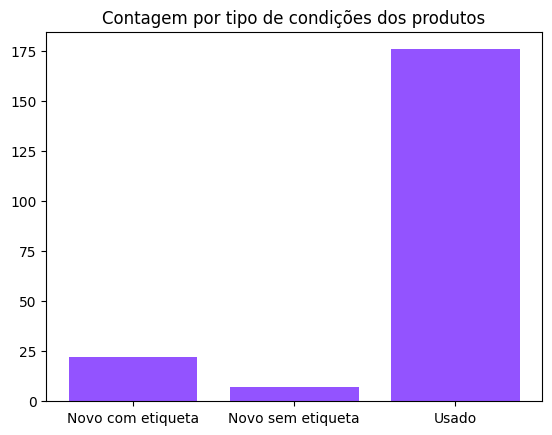

In [50]:
plt.bar(df_produtos['Condicao'], df_produtos['Quantidade'], color = '#9353FF')
plt.title('Contagem por tipo de condições dos produtos')
plt.show()

Now, we need to rank the most frequently ordered products by quantity to better understand inventory needs for the store.

In [51]:
sql_df('SELECT * FROM produtos').head(3)

,produto_id,produto,preco,marca,sku,Condicao
0,21244,Oculos Lente Azulada,1120,D&g Dolce & Gabbana,209297,Usado
1,9981,Bolsa Coral Saco,4000,Givenchy,278612,Usado
2,84176,Camisa Xadrez Verde,310,Joe Fresh,322482,Usado


In [52]:
sql_df('SELECT * FROM itens_pedidos').head(3)

,id_nf,produto_id,pedido_id,quantidade,valor_unitario,valor_total,Estado,frete
0,1,41518,341,3,260,780,BR-BA,156.0
1,2,4307,1174,5,6175,30875,BR-RJ,6175.0
2,3,22407,1399,3,200,600,BR-PB,120.0


In [53]:
query = '''SELECT produtos.produto, SUM(itens_pedidos.quantidade) AS Quantidade
           FROM itens_pedidos, produtos
           WHERE itens_pedidos.produto_id = produtos.produto_id
           GROUP BY produtos.produto
           ORDER BY Quantidade ASC'''

df_prod_quant = sql_df(query)
df_prod_quant

,produto,Quantidade
0,Vestido Malha Estampa,318
1,Blusa Listrada Malha,322
2,Blusa Malha Azul,325
3,Blusa Babados Off-white,337
4,Blusa Cinza,341
...,...,...
196,Saia Midi Cinto,549
197,Calca Alfaiataria Preta,750
198,Saia Pregas Preta,751
199,Calca Jeans Costuras,755


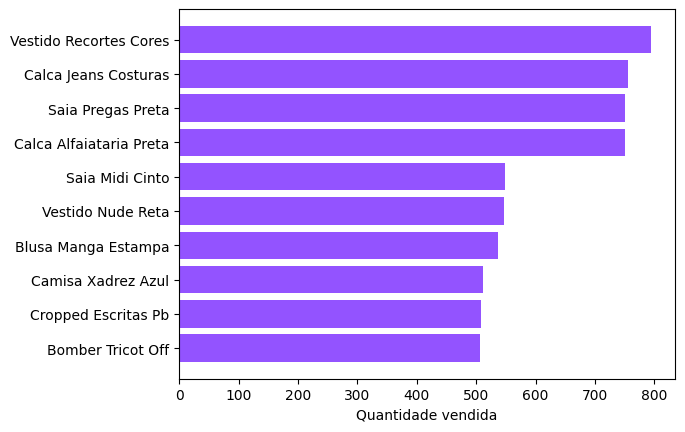

In [54]:
plt.barh(df_prod_quant['produto'][-10:], df_prod_quant['Quantidade'][-10:], color = '#9353FF')
plt.xlabel('Quantidade vendida')
plt.show()

In [55]:
query = '''SELECT SUM(itens_pedidos.quantidade * itens_pedidos.valor_unitario) AS 'Receita Total'
FROM itens_pedidos'''
sql_df(query)

,Receita Total
0,45803930


In [56]:
query = '''SELECT produtos.marca, SUM(itens_pedidos.quantidade) AS Soma
FROM produtos, itens_pedidos
WHERE itens_pedidos.produto_id = produtos.produto_id
GROUP BY produtos.marca
ORDER BY Soma DESC'''

sql_df(query).head(15)

,marca,Soma
0,Zara,9545
1,Mixed,5748
2,Animale,4013
3,Le Lis Blanc,2479
4,Banana Republic,2045
5,Farm,1779
6,H&m,1576
7,Shoulder,1317
8,Sacada,1285
9,Dress&co,1262


# 3. Working with Filters

Let’s begin analyzing the performance of Meteora’s sales team. The goal here is to understand their sales in the previous year so that promotions and bonuses can be applied in the current year shown in the dataset, which is 2021.

In [57]:
sql_df('SELECT * FROM pedidos').head(3)

,pedido_id,produto_id,vendedor_id,data_compra,total
0,341,41518,5,2019-01-05,780
1,1174,4307,3,2019-01-05,30875
2,1399,22407,1,2019-01-05,600


In [58]:
sql_df('SELECT * FROM pedidos').info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24527 entries, 0 to 24526
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   pedido_id    24527 non-null  int64 
 1   produto_id   24527 non-null  int64 
 2   vendedor_id  24527 non-null  int64 
 3   data_compra  24527 non-null  object
 4   total        24527 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 958.2+ KB


To evaluate the sales performance of the team in 2020, we need to work with the data specifically from that year.

In [65]:
query = '''SELECT  vendedores.nome_vendedor, AVG(pedidos.total) AS 'Valor médio por vendas'
           FROM pedidos, vendedores
           WHERE strftime('%Y', data_compra) = '2020' AND vendedores.vendedor_id = pedidos.vendedor_id
           GROUP BY vendedores.nome_vendedor
           ORDER BY AVG(pedidos.total) DESC;
'''

sql_df(query)

,nome_vendedor,Valor médio por vendas
0,Daniel Siqueira,1972.338526
1,Millena Pereira,1894.614343
2,Ana Duarte,1843.452582
3,Nadia Oliveira,1818.342200
4,Paulo Calanca,1813.469855


In [69]:
query = ''' SELECT * FROM produtos
'''
sql_df(query).head()

,produto_id,produto,preco,marca,sku,Condicao
0,21244,Oculos Lente Azulada,1120,D&g Dolce & Gabbana,209297,Usado
1,9981,Bolsa Coral Saco,4000,Givenchy,278612,Usado
2,84176,Camisa Xadrez Verde,310,Joe Fresh,322482,Usado
3,47475,Calca Alfaiataria Preta,490,Mixed,263658,Usado
4,74864,Vestido Jeans Babados,130,Zara,219248,Usado


In [71]:
query = ''' SELECT * FROM pedidos
'''
sql_df(query).head()

,pedido_id,produto_id,vendedor_id,data_compra,total
0,341,41518,5,2019-01-05,780
1,1174,4307,3,2019-01-05,30875
2,1399,22407,1,2019-01-05,600
3,1652,3820,4,2019-01-05,834
4,2470,29012,2,2019-01-05,1575


In [77]:
query = ''' SELECT produtos.produto, COUNT(pedidos.pedido_id) AS TOTAL_PEDIDOS
            FROM produtos, pedidos
            WHERE strftime('%Y', pedidos.data_compra) = '2019' AND produtos.produto_id = pedidos.produto_id
            GROUP BY produtos.produto
            ORDER BY TOTAL_PEDIDOS DESC
            LIMIT 10;
'''

sql_df(query)

,produto,TOTAL_PEDIDOS
0,Vestido Recortes Cores,85
1,Calca Jeans Costuras,81
2,Saia Pregas Preta,73
3,Calca Alfaiataria Preta,66
4,Camisa Xadrez Azul,60
5,Bomber Tricot Off,56
6,Shorts Bordado Branco,55
7,Blusa Manga Estampa,54
8,Saia Midi Cinto,53
9,Saia Evase Cinza,53


In [78]:
query = '''SELECT strftime('%m', data_compra) AS mes, SUM(total) AS receita
           FROM pedidos
           WHERE strftime('%Y', data_compra) = '2021'
           GROUP BY mes;
'''

sql_df(query)

,mes,receita
0,01,2097109
1,02,1140729
2,03,51525


# 4. Deepening Relationships

Meteora now wants to boost its sales in the state of São Paulo (SP), believing it to be a region with high sales potential due to population density and market activity.

But is São Paulo already generating a significant number of sales compared to other states?

In [80]:
query = ''' SELECT  estado, COUNT(*) AS Pedidos
            FROM itens_pedidos
            GROUP BY estado
            ORDER BY Pedidos DESC;
'''

sql_df(query)

,Estado,Pedidos
0,BR-MA,974
1,BR-DF,953
2,BR-MT,937
3,BR-GO,933
4,BR-PA,932
5,BR-AL,928
6,BR-PE,927
7,BR-RR,925
8,BR-RO,925
9,BR-RN,921


One strategy Meteora intends to implement in SP is selecting two of its sellers to focus their sales efforts there. To make this choice, it’s useful to identify the professionals who have already sold the most to customers in that region.

In [84]:
query = ''' SELECT vendedores.nome_vendedor, COUNT(*) AS quantidade_vendas
            FROM pedidos
            JOIN vendedores ON vendedores.vendedor_id = pedidos.vendedor_id
            JOIN itens_pedidos ON itens_pedidos.pedido_id = pedidos.pedido_id
            WHERE itens_pedidos.estado = 'BR-SP'
            GROUP BY vendedores.nome_vendedor
            ORDER BY quantidade_vendas DESC;
'''

sql_df(query)

,nome_vendedor,quantidade_vendas
0,Daniel Siqueira,190
1,Paulo Calanca,182
2,Nadia Oliveira,181
3,Ana Duarte,180
4,Millena Pereira,157


In [85]:
query = '''SELECT PRODUTOS.MARCA, COUNT(*) AS 'Produtos vendidos'
FROM PRODUTOS
JOIN ITENS_PEDIDOS ON ITENS_PEDIDOS.PRODUTO_ID = PRODUTOS.PRODUTO_ID
WHERE ITENS_PEDIDOS.ESTADO = 'BR-SP'
GROUP BY PRODUTOS.MARCA
ORDER BY COUNT(ITENS_PEDIDOS.PRODUTO_ID) DESC;
'''
df_marcas_sp = sql_df(query)
df_marcas_sp

,marca,Produtos vendidos
0,Zara,100
1,Mixed,58
2,Animale,44
3,Le Lis Blanc,26
4,Banana Republic,18
...,...,...
111,Topshop,1
112,Morena Rosa,1
113,Erre Erre,1
114,Bobô,1


In [86]:
query = '''SELECT PRODUTOS.PRODUTO, COUNT(*) AS quantidade_vendas
FROM ITENS_PEDIDOS
JOIN produtos ON produtos.produto_id = ITENS_PEDIDOS.produto_id
JOIN PEDIDOS ON PEDIDOS.PEDIDO_ID = ITENS_PEDIDOS.PEDIDO_ID
WHERE strftime('%m',PEDIDOS.data_compra)= '12'
GROUP BY produtos.produto
ORDER BY quantidade_vendas DESC;
'''
sql_df(query)

,produto,quantidade_vendas
0,Vestido Recortes Cores,30
1,Vestido Preto Franzido,26
2,Calca Jeans Costuras,26
3,Calca Alfaiataria Preta,26
4,Camisa Xadrez Azul,25
...,...,...
196,Sneaker Monograma Bege,6
197,Casaqueto Estampa Geometrica,6
198,Regata Renda Branca,5
199,Body Estampa Coracoes,5
